# Feature Analysis

In [1]:
import pandas as pd
import math

In [2]:
filenames1 = ['pionminus','pionminus1','pionminus2','pionminus3','pionminus4','pionminus5']
filenames1 = ['ccbar0']
filenames2 = ['photon_100M_v0','photon_100M_v1']
filepath = "/home/yoren/bnl/PHENIX/ee/ML/"

hadron_weight = 25000*50/500

In [3]:
if True:
    data = pd.read_csv(filepath+f'{filenames1[0]}.csv')
    for ifile in range(1,len(filenames1)):
        idata = pd.read_csv(filepath+f'{filenames1[ifile]}.csv')
        data = pd.concat([data,idata], sort=False)
    data.loc[data['IsTrue0'] > -99, 'IsTrue0'] = 1

    for ifile in range(0,len(filenames2)):
        idata = pd.read_csv(filepath+f'{filenames2[ifile]}.csv')
        idata.loc[idata['IsTrue0'] > -99, 'IsTrue0'] = 0
        data = pd.concat([data,idata], sort=False)

    data = data.sample(frac = 1)
    float_columns=('Pt', 'Phi0', 'The0', 'PhiDC', 'ZDC', 'Alpha', 'Ecore',\
                   'sdphi0','sdthe0','SecondHitPhiR0','SecondHitPhiL0','SecondHitTheR0','SecondHitTheL0',\
                   'sdphi1','sdthe1','SecondHitPhiR1','SecondHitPhiL1','SecondHitTheR1','SecondHitTheL1',\
                   'sdphi2','sdthe2','SecondHitPhiR2','SecondHitPhiL2','SecondHitTheR2','SecondHitTheL2',\
                   'sdphi3','sdthe3','SecondHitPhiR3','SecondHitPhiL3','SecondHitTheR3','SecondHitTheL3')
    int_columns=('NBDThit','Centrality', 'Charge', 'Arm','IsTrue0','IsTrue1','IsTrue2','IsTrue3')
    
    for float_column in float_columns:
        data[float_column] = data[float_column].astype('float16')
    for int_column in int_columns:
        data[int_column] = data[int_column].astype('int32')
        
    data = data[(data['Pt'] < 25) & (data['Ecore'] > 0.1) & (data['Ecore'] < 25) ]
    

    data.head()

In [4]:
data.head()

,NBDThit,Pt,Phi0,The0,PhiDC,ZDC,Alpha,Ecore,Centrality,Charge,...,SecondHitPhiL2,SecondHitTheR2,SecondHitTheL2,sdphi3,sdthe3,IsTrue3,SecondHitPhiR3,SecondHitPhiL3,SecondHitTheR3,SecondHitTheL3
2314064,4,0.682129,3.843750,1.252930,3.521484,71.687500,0.167969,1.052734,2,-1,...,21.656250,-99.000000,-1.677734,-1.021484,-1.734375,0,-0.709961,34.593750,-2.958984,17.750000
958331,25,0.396729,-0.874023,1.227539,-0.329590,76.562500,-0.280762,0.436768,37,1,...,-99.000000,-99.000000,-99.000000,0.162231,-0.044769,0,0.000000,2.531250,0.000000,-4.117188
230593,12,0.497314,0.472412,1.784180,0.044708,-46.218750,0.215576,0.680176,13,-1,...,3.351562,-99.000000,1.052734,-1.170898,-0.444092,0,-0.000000,4.984375,0.000000,-9.031250
2874181,14,0.430176,-0.964355,1.665039,-0.485596,-20.953125,-0.233276,0.484375,10,1,...,10.210938,7.640625,-0.694824,-0.967285,-1.084961,0,0.000000,16.656250,0.000000,-8.773438
1560896,3,0.643555,2.599609,1.438477,2.279297,28.859375,0.159912,0.475586,25,-1,...,45.093750,23.281250,9.820312,-0.177979,-0.182617,1,-33.093750,36.031250,-0.756836,-12.867188


In [5]:
print(data.size, data.shape)

218789376 (5609984, 39)


In [6]:
# удалим лишние колонки
data = data.drop(columns = ['IsTrue1','IsTrue2','IsTrue3'])

In [7]:
import matplotlib.pyplot as plt

def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(4, 3, figsize=(15, 6))
    for i, feature in enumerate(['IsTrue0', 'Pt', 'Phi0', 'The0', 'PhiDC', 'ZDC', 'Alpha', 'Ecore' , 'sdphi0', 'sdphi1', 'sdphi2', 'sdphi3']):
        x, y = divmod(i, 3)
        data[feature].plot.hist(ax=ax[x][y], ylabel='', title=feature, color='skyblue', logy=True)


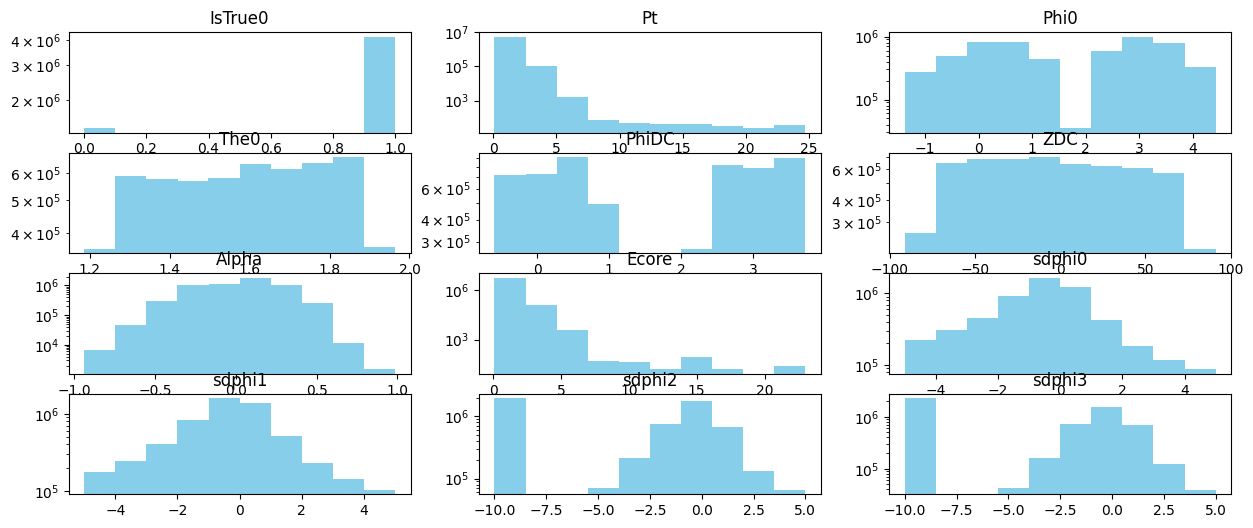

In [8]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [9]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # делим выборку на train и test
    #data = data.sort_values(by='date_time', ignore_index=True)
    #cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    #cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)

    y = data['IsTrue0']
    data = data.drop(columns = ['IsTrue0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    #enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    #enc.fit(data_train)
    #transformed_train = enc.transform(data_train)
    #transformed_test = enc.transform(data_test)
    
    return data_train, data_test, y_train, y_test,cut_off_val

In [10]:
X_train_all, X_test, y_train_all, y_test, cut_off_val = feature_engineering(data)

1869994 3739990


In [11]:
X_test

,NBDThit,Pt,Phi0,The0,PhiDC,ZDC,Alpha,Ecore,Centrality,Charge,...,SecondHitPhiR2,SecondHitPhiL2,SecondHitTheR2,SecondHitTheL2,sdphi3,sdthe3,SecondHitPhiR3,SecondHitPhiL3,SecondHitTheR3,SecondHitTheL3
307571,1,0.598633,3.500000,1.622070,3.154297,-10.703125,0.171021,0.490723,8,-1,...,-99.000000,36.437500,-99.000000,-3.824219,0.344971,1.166992,-10.515625,4.574219,-1.190430,-8.046875
96405,4,0.218628,4.144531,1.390625,3.138672,36.687500,0.485352,0.170166,51,-1,...,-0.000000,-99.000000,0.000000,-99.000000,0.553711,-0.483398,-0.000000,-99.000000,0.000000,-99.000000
2071517,9,0.294678,-1.089844,1.430664,-0.371094,30.953125,-0.355225,0.280029,6,1,...,2.732422,0.775391,-7.746094,7.292969,-0.653809,-0.169922,-8.507812,6.183594,12.406250,0.485352
1632050,1,0.653320,3.248047,1.758789,2.929688,-41.343750,0.162231,0.574219,91,-1,...,-99.000000,-99.000000,-99.000000,-99.000000,1.175781,1.032227,-99.000000,-99.000000,-99.000000,-99.000000
1799970,5,0.531250,-0.392822,1.612305,-0.003513,-8.257812,-0.192627,0.476318,28,1,...,0.873047,22.890625,-4.117188,-18.468750,-10.000000,-10.000000,-99.000000,26.109375,-99.000000,-18.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4353714,4,0.460938,0.858398,1.837891,0.392334,-58.406250,0.237061,0.513672,90,-1,...,-99.000000,-99.000000,-99.000000,-99.000000,0.106873,3.052734,-0.000000,-99.000000,3.802734,-99.000000
5173564,3,0.317627,2.556641,1.438477,3.230469,25.453125,-0.329834,0.160400,47,1,...,-99.000000,-99.000000,-99.000000,-99.000000,-10.000000,-10.000000,-99.000000,-99.000000,-99.000000,-99.000000
1656338,3,0.707031,3.230469,1.459961,2.937500,23.968750,0.146362,0.682617,38,-1,...,-99.000000,-99.000000,-99.000000,-99.000000,0.533691,0.403320,-99.000000,-99.000000,-99.000000,-99.000000
4219836,10,0.460449,3.033203,1.544922,2.585938,6.152344,0.220093,0.327637,18,-1,...,-99.000000,15.765625,-99.000000,9.257812,-1.416992,-0.228149,0.925293,16.343750,4.980469,8.781250


In [12]:
X_train, X_val = X_train_all[:cut_off_val], X_train_all[cut_off_val:]
y_train, y_val = y_train_all[:cut_off_val], y_train_all[cut_off_val:]
w_train, w_val = y_train-1, y_val-1
w_test = y_test-1
w_train_all = y_train_all - 1
w_train = w_train*(-hadron_weight)+1
w_val = w_val*(-hadron_weight)+1
w_test = w_test*(-hadron_weight)+1
w_train_all = w_train_all*(-hadron_weight)+1

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [13]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate= 0.1, max_features=2, max_depth=2, random_state=0)
gb_clf.fit(X_train, y_train, w_train)

predicted = gb_clf.predict(X_test)

# calculating the main quality metrics
print(metrics.classification_report(y_test, predicted))

print('confusion matrix')
print(metrics.confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

           0       0.27      1.00      0.42    482130
           1       1.00      0.05      0.10   1387864

    accuracy                           0.30   1869994
   macro avg       0.63      0.53      0.26   1869994
weighted avg       0.81      0.30      0.19   1869994

confusion matrix
[[ 482110      20]
 [1312670   75194]]


In [14]:
# search for parameters
# https://www.kaggle.com/hatone/gradientboostingclassifier-with-gridsearchcv
import time
from sklearn.model_selection import GridSearchCV

start = time.time() 

parameters = {
    "loss":["log_loss"],
    "learning_rate": [0.01, 0.2],
    "min_samples_split": [0.01, 0.2],
    "max_depth":[12],
    "max_features":["log2","sqrt"],
    "criterion": ['squared_error'],
    "n_estimators":[20]
    }

classif = GradientBoostingClassifier()
classif.set_params(init='zero')

clf = GridSearchCV(classif, parameters, cv=3, n_jobs=8)

clf.fit(X_train, y_train, sample_weight=w_train)
print('точность: ', clf.score(X_test, y_test))

# getting the best parameters ans score
print(clf.best_params_)
print(clf.best_score_)

stop = time.time()    
print('time of execution (sec)', stop - start)

точность:  0.4969310061957418
{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 12, 'max_features': 'log2', 'min_samples_split': 0.01, 'n_estimators': 20}
0.49470159745546277
time of execution (sec) 426.583425283432


# Cross Validation

In [15]:
predicted = clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.34      1.00      0.51    482130
           1       1.00      0.32      0.49   1387864

    accuracy                           0.50   1869994
   macro avg       0.67      0.66      0.50   1869994
weighted avg       0.83      0.50      0.49   1869994



In [16]:
y_pred_probs = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# Model Evaluation

log loss: 0.011987888785555033
roc auc: 0.974847681671821
f1 score: 0.9359926027347465


Text(0.5, 1.0, 'ROC AUC Curve')

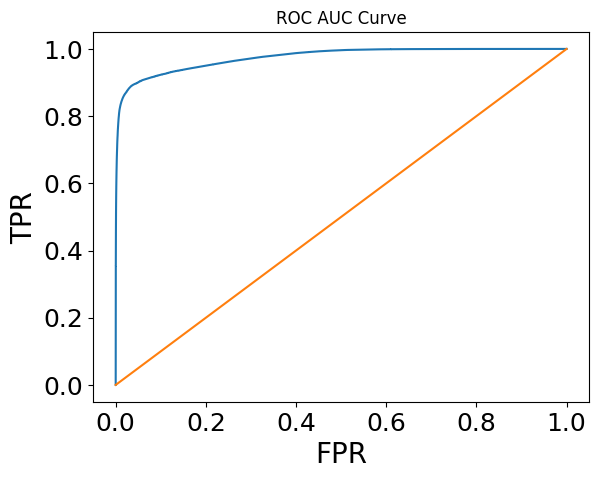

In [17]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score

print('log loss:', log_loss(y_test, y_pred_probs, sample_weight=w_test))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1, sample_weight=w_test)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
plt.xticks(fontsize = 18) 
plt.yticks(fontsize = 18) 
plt.title('ROC AUC Curve')

In [30]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.13832714192070625


In [41]:
i = 160000
print(round(tpr[i],3),round(fpr[i]/tpr[i],4))
print(thresholds[i],fpr[i],tpr[i])
#print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.812 0.0096
0.023429009621297826 0.007782133449484579 0.8115953724572437


In [24]:
print(sum(predicted),len(predicted))

447314 1869994


In [25]:
kek_data = data
kek_data = kek_data.drop(columns = ['IsTrue0'])
proba_loc = clf.predict_proba(kek_data)
print(proba_loc[0][1])

0.025722562597584882


In [97]:
import ROOT as root
outfile = root.TFile.Open("output/BDT_Conv.root", "recreate")
e_pt_hist_AI = root.TH2D("e_pt_hist_AI", "e_pt_hist_AI", 50, 0, 5, 10, 0, 100)
h_pt_hist_AI = root.TH2D("h_pt_hist_AI", "h_pt_hist_AI", 50, 0, 5, 10, 0, 100)
e_pt_hist_SC = root.TH2D("e_pt_hist_SC", "e_pt_hist_SC", 50, 0, 5, 10, 0, 100)
h_pt_hist_SC = root.TH2D("h_pt_hist_SC", "h_pt_hist_SC", 50, 0, 5, 10, 0, 100)
e_pt_hist_NC = root.TH2D("e_pt_hist_NC", "e_pt_hist_NC", 50, 0, 5, 10, 0, 100)
h_pt_hist_NC = root.TH2D("h_pt_hist_NC", "h_pt_hist_NC", 50, 0, 5, 10, 0, 100)

In [98]:
mycute,mycuth, AIcute, AIcuth = 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = data.reset_index()  # make sure indexes pair with number of rows

sigma, sigma_veto = 3, -2

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>4000000: break
    sdphi0, sdphi1, sdphi2, sdphi3 = row['sdphi0'], row['sdphi1'], row['sdphi2'], row['sdphi3']
    sdthe0, sdthe1, sdthe2, sdthe3 = row['sdthe0'], row['sdthe1'], row['sdthe2'], row['sdthe3']
    centrality, pt, IsTrue0 = row['Centrality'], row['Pt'], row['IsTrue0']

    if pt<0.4 or centrality<0: continue
    
    if IsTrue0: e_pt_hist_NC.Fill(pt,centrality)
    else:    h_pt_hist_NC.Fill(pt,centrality)
    if sdphi0>sigma_veto and ( abs(sdphi0) < sigma and abs(sdthe0) < sigma and abs(sdphi1) < sigma and abs(sdthe1) < sigma ) and ( ( abs(sdphi2) < sigma and abs(sdthe2) < sigma ) or ( abs(sdphi3) < sigma and abs(sdthe3) < sigma ) ):
        if IsTrue0: 
            mycute+=1
            e_pt_hist_SC.Fill(pt,centrality)
        else: 
            mycuth+=1+hadron_weight
            h_pt_hist_SC.Fill(pt,centrality)
    if proba_loc[counter][1]>thresholds[i]: 
        if IsTrue0: 
            AIcute+=1
            e_pt_hist_AI.Fill(pt,centrality)
        else: 
            AIcuth+=1+hadron_weight
            h_pt_hist_AI.Fill(pt,centrality)
    if IsTrue0: norm_e+=1
    else: norm_h+=1+hadron_weight
    #if counter<10: 
    #    print(proba_loc[counter],answer(centrality,pt,ep,n0,disp,chi2,npe0,prob))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

In [42]:
print(norm_e, norm_h,round(mycute/norm_e,3),round(mycuth/norm_h,3), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i]/tpr[i],3))

515715 457765533.0 0.752 0.498 0.887 0.012 0.014 0.01


In [51]:
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h))

76.65 1.132 0.015 3477


In [100]:
e_pt_hist_AI.Write()
h_pt_hist_AI.Write()
e_pt_hist_SC.Write()
h_pt_hist_SC.Write()
e_pt_hist_NC.Write()
h_pt_hist_NC.Write()
outfile.Close()

In [82]:
%run input/Format.ipynb

/home/yoren/.local/lib/python3.10/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


6218.0 17099.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


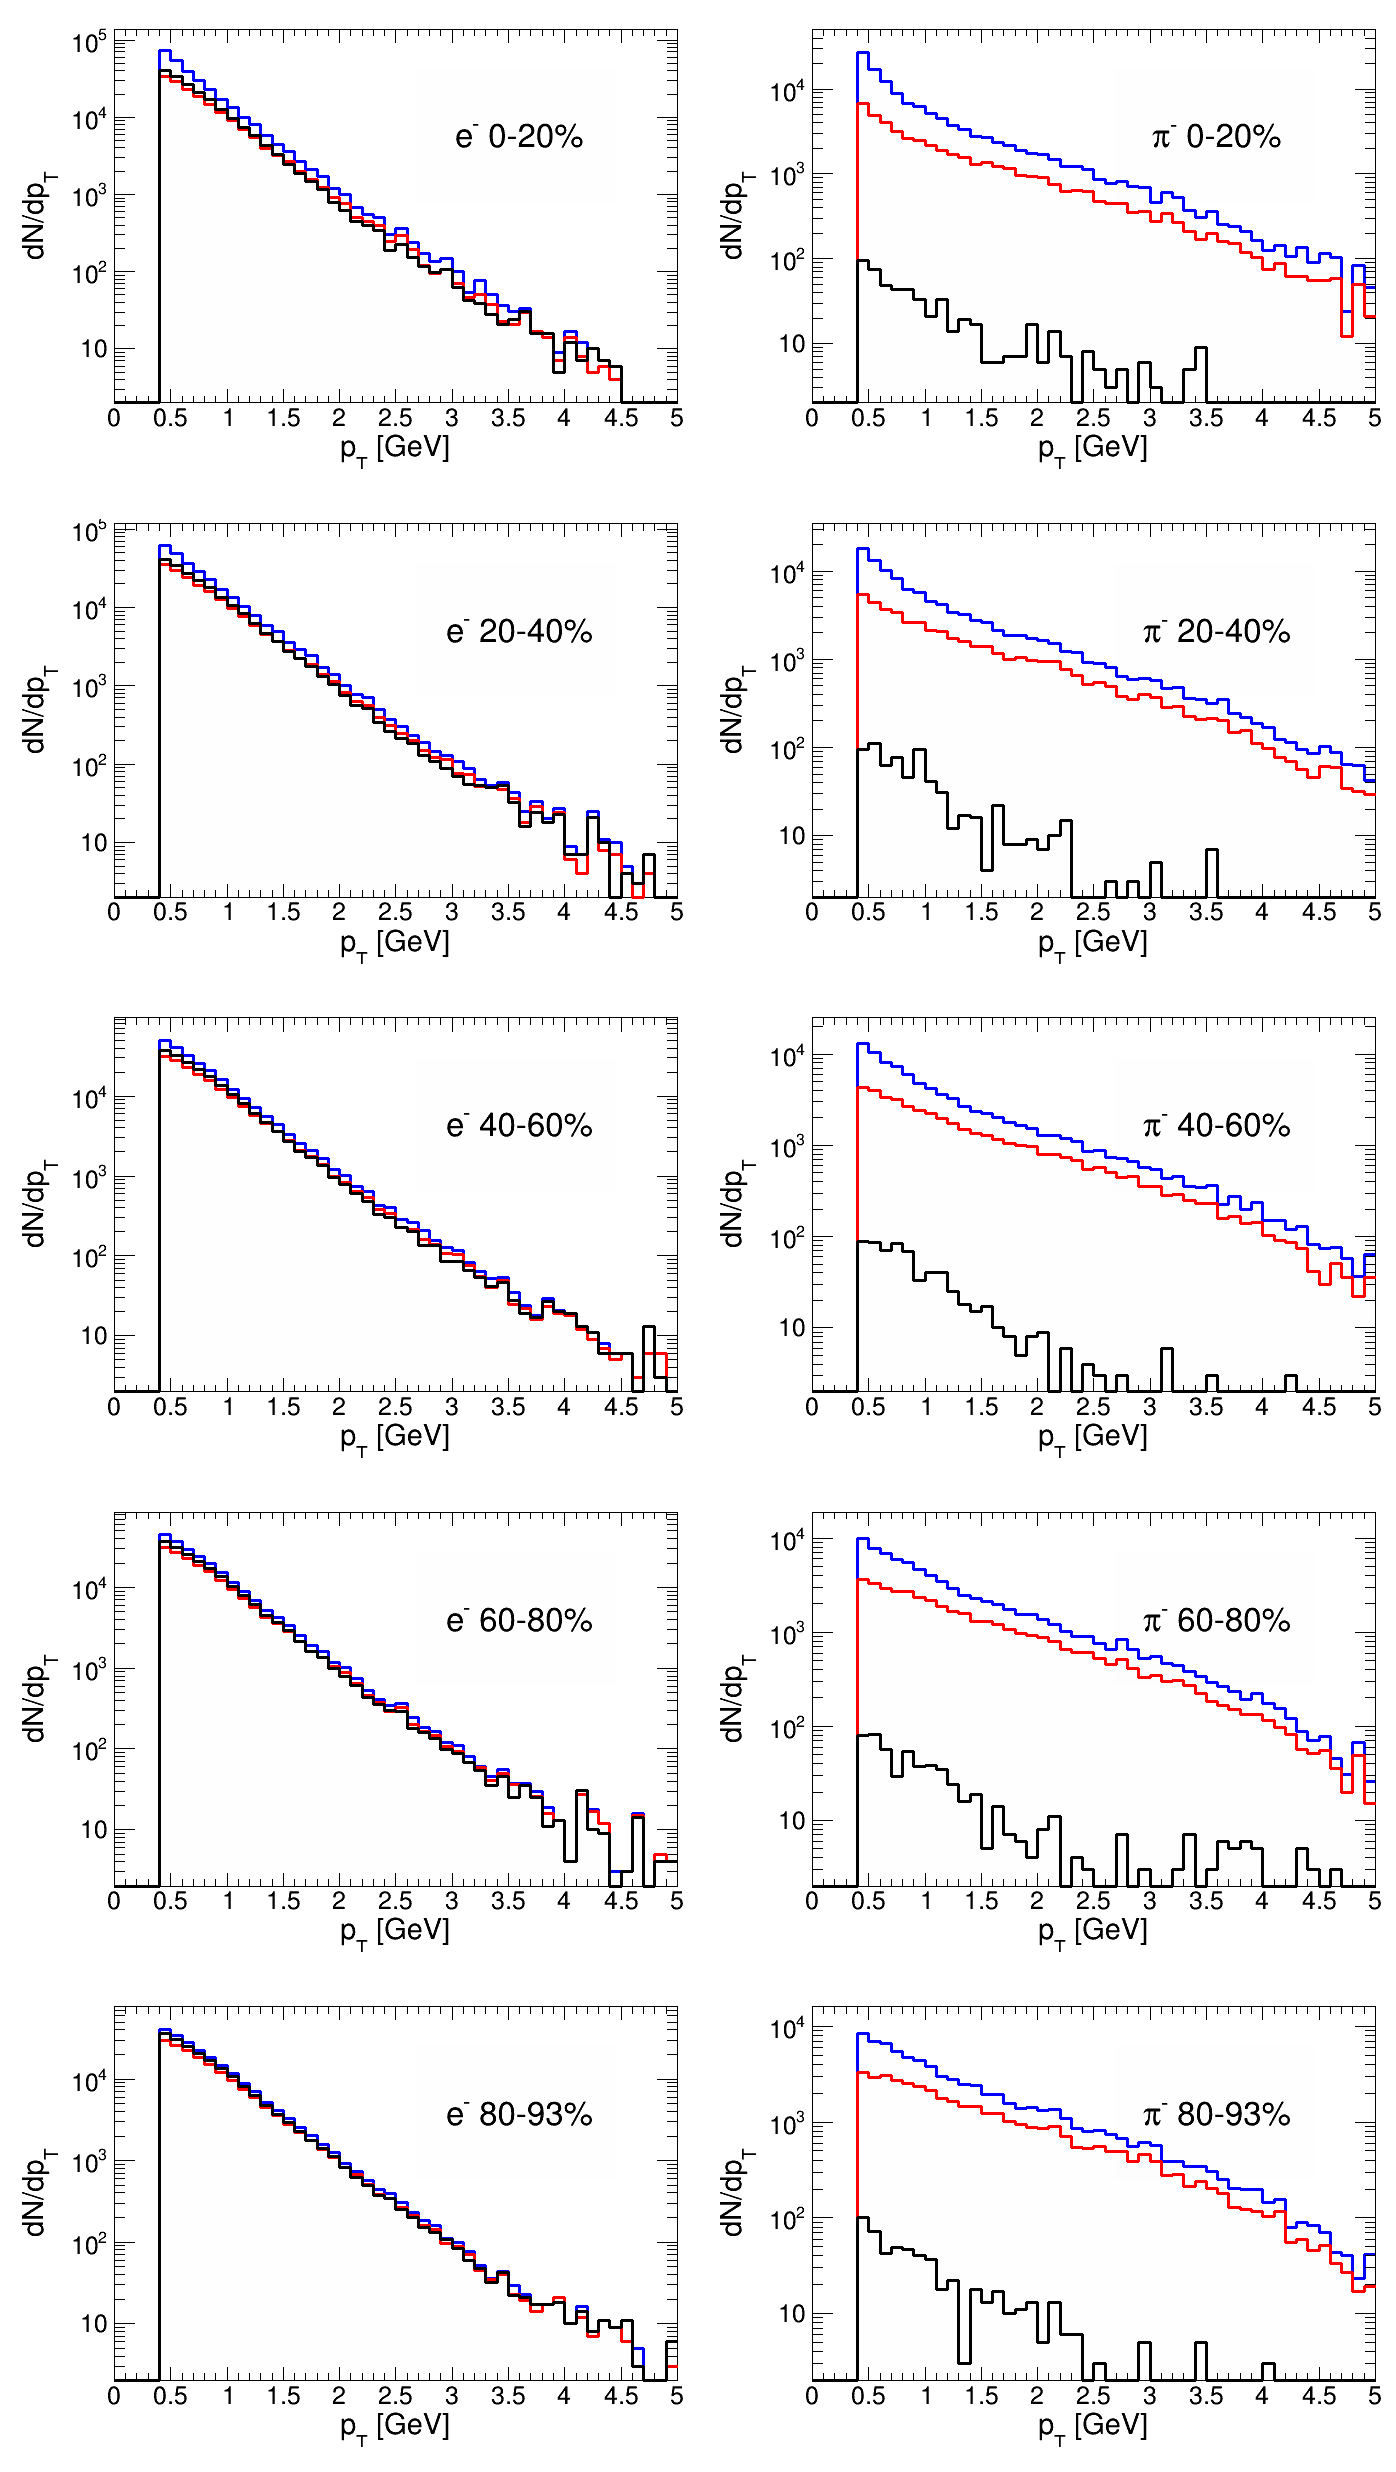

In [99]:
c1 = root.TCanvas("c1","c1",1400,2500)
c1.Divide(2,5)
part_names_legend= [ "e^{-} " , "#pi^{-} "]
centralities_legend = ["0-20%","20-40%","40-60%","60-80%","80-93%"]
legends = []
for icentr in range(5):

    c1.cd(1+2*icentr)
    root.gPad.SetLogy()
    e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}").SetLineWidth(3)
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}").SetLineWidth(3)
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}").SetLineWidth(3)
    e_pt_hist_NC.SetLineColor(4)
    e_pt_hist_SC.SetLineColor(2)
    e_pt_hist_AI.SetLineColor(1)
    proj = e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}",icentr+1,icentr+1)
    proj.SetMinimum(2)
    Format_Hist_total(proj, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    proj.Draw()
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}",icentr+1,icentr+1).Draw("same")
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",icentr+1,icentr+1).Draw("same")

    legends.append(Draw_Legend_Title(0.6,0.6,0.9,0.9,part_names_legend[0]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].Draw()

    c1.cd(2+2*icentr)
    root.gPad.SetLogy()
    h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}").SetLineWidth(3)
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}").SetLineWidth(3)
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}").SetLineWidth(3)
    h_pt_hist_NC.SetLineColor(4)
    h_pt_hist_SC.SetLineColor(2)
    h_pt_hist_AI.SetLineColor(1)
    projh = h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}",icentr+1,icentr+1)
    Format_Hist_total(projh, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    projh.SetMinimum(2)
    projh.Draw()
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}",icentr+1,icentr+1).Draw("same")
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",icentr+1,icentr+1).Draw("same")

    legends.append(Draw_Legend_Title(0.6,0.6,0.9,0.9,part_names_legend[1]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].Draw()
c1.Draw()
print(h_pt_hist_NC.GetBinContent(10,1),e_pt_hist_NC.GetBinContent(10,1))

In [101]:
import pickle
with open('output/bdt_conv.pkl','wb') as f:
    pickle.dump(clf,f)

print(clf.predict(kek_data[0:10]))

[0 0 0 0 0 0 0 0 0 0]


In [102]:
import pickle
# load
with open('output/bdt_conv.pkl', 'rb') as f:
    clf2 = pickle.load(f)
print(clf2.predict(kek_data[0:10]))

[0 0 0 0 0 0 0 0 0 0]


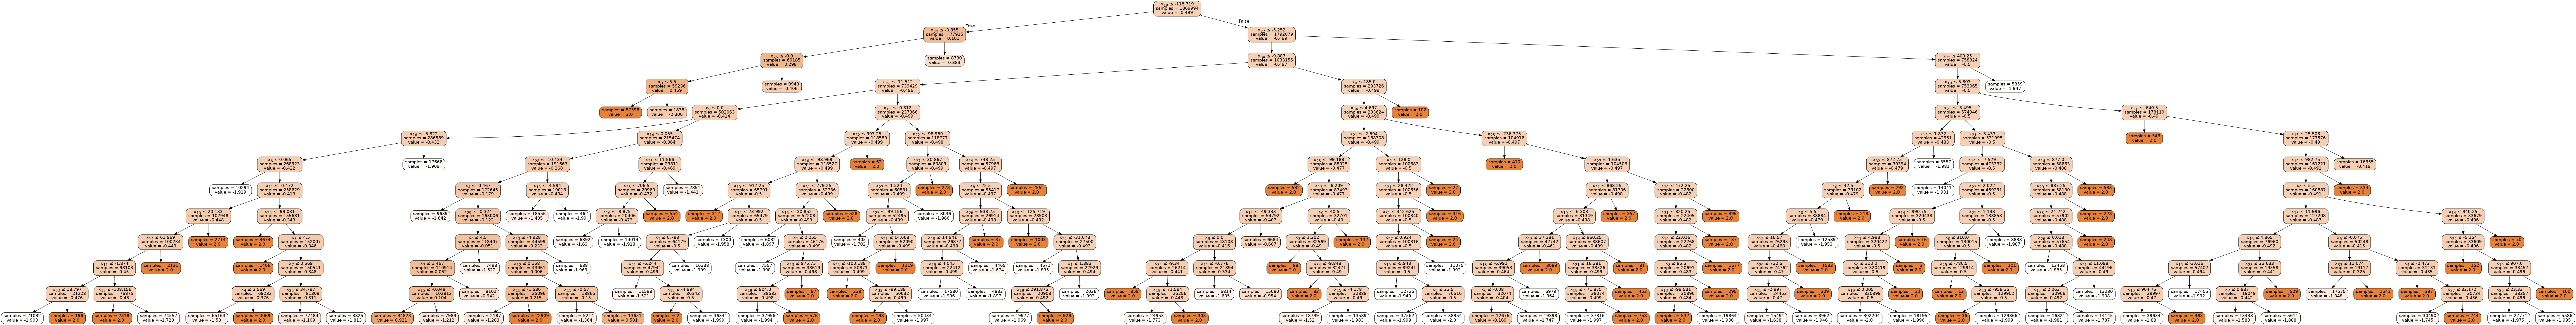

In [103]:
sub_tree_42 = clf2.best_estimator_[0, 0]
from sklearn.tree import export_graphviz, export_text
from sklearn.tree import _tree
# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)

graph = graph_from_dot_data(dot_data)
png = graph.create_png()
# Save (optional)
from pathlib import Path
Path('output/out.png').write_bytes(png)
# Display
Image(png)

In [104]:
clf2.predict(kek_data[0:100])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int32)

In [105]:
clf2.predict_proba(kek_data[0:100])

array([[0.97427744, 0.02572256],
       [0.99120788, 0.00879212],
       [0.99064482, 0.00935518],
       [0.93648929, 0.06351071],
       [0.91712221, 0.08287779],
       [0.86689108, 0.13310892],
       [0.79462242, 0.20537758],
       [0.9026885 , 0.0973115 ],
       [0.99136204, 0.00863796],
       [0.94875481, 0.05124519],
       [0.87800528, 0.12199472],
       [0.88506468, 0.11493532],
       [0.92521307, 0.07478693],
       [0.65675705, 0.34324295],
       [0.86975836, 0.13024164],
       [0.50340882, 0.49659118],
       [0.98942977, 0.01057023],
       [0.88585357, 0.11414643],
       [0.99138282, 0.00861718],
       [0.19491705, 0.80508295],
       [0.99126854, 0.00873146],
       [0.03135026, 0.96864974],
       [0.99137293, 0.00862707],
       [0.8864655 , 0.1135345 ],
       [0.04205709, 0.95794291],
       [0.23080074, 0.76919926],
       [0.11064309, 0.88935691],
       [0.0126993 , 0.9873007 ],
       [0.99121552, 0.00878448],
       [0.39389963, 0.60610037],
       [0.

In [106]:
print( clf2.best_params_)

{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 12, 'max_features': 'log2', 'min_samples_split': 0.01, 'n_estimators': 20}


In [107]:
clf2.best_estimator_.predict_proba(kek_data[9:20])

array([[0.94875481, 0.05124519],
       [0.87800528, 0.12199472],
       [0.88506468, 0.11493532],
       [0.92521307, 0.07478693],
       [0.65675705, 0.34324295],
       [0.86975836, 0.13024164],
       [0.50340882, 0.49659118],
       [0.98942977, 0.01057023],
       [0.88585357, 0.11414643],
       [0.99138282, 0.00861718],
       [0.19491705, 0.80508295]])

In [108]:
y = clf2.best_estimator_[0, 0].predict(kek_data[9:19].values.tolist())*0
#y = gb_clf.decision_function(kek_data[9:20])

rate = clf2.best_params_['learning_rate']
print(rate)
for i in range(0,10):
    sub_tree = clf2.best_estimator_[i, 0]
    y += rate*sub_tree.predict(kek_data[9:19].values.tolist())
print(y)
print(gb_clf.decision_function(kek_data[9:20]))
z=y
for i in range(len(z)): 
    z[i] = 1./(1+np.exp(-z[i]))
print(z)

0.2
[-2.23591362 -1.98277225 -1.78007729 -2.60420561 -2.45846203 -1.79324099
 -1.00676365 -2.65082378 -2.0875802  -2.69376399]
[-5.22351148 -7.01084799 -2.5342039  -6.13635483 -6.6150167  -6.40894321
 -2.32463766 -6.45894061 -5.74779089 -7.24399165 -2.28285627]
[0.09657147 0.12102362 0.14429359 0.06886824 0.07882194 0.14267583
 0.26761369 0.06593825 0.11030983 0.06334233]


In [109]:
best_gbc = clf2.best_estimator_

In [110]:
n_estim = best_gbc.n_estimators

In [111]:
learning_rate = best_gbc.learning_rate
print(clf2.decision_function(kek_data[9:19]))
arr = clf2.decision_function(kek_data[9:19])
print(1./(1.+np.exp(-arr)))
#tree_scores = [best_gbc.estimators_[i, 0].decision_function(kek_data[9:19].values.tolist()) for i in range(10)]
print(learning_rate)

[-2.91852865 -1.97367482 -2.04129116 -2.51538085 -0.64887568 -1.89882392
 -0.01363551 -4.53908715 -2.04906959 -4.74534304]
[0.05124519 0.12199472 0.11493532 0.07478693 0.34324295 0.13024164
 0.49659118 0.01057023 0.11414643 0.00861718]
0.2


In [112]:
log_odds_predictions = []
for tree in clf2.best_estimator_:
    # For each tree, get the predicted values for each sample
    leaf_indices = tree[0].apply(kek_data[9:19].values.tolist())  # Get the leaf indices for the training data
    leaf_values = tree[0].tree_.value  # Get the values at each leaf

    # Average the values for each leaf to interpret them as log odds
    predicted_log_odds = [leaf_values[leaf_indices[i]].mean() for i in range(len(kek_data[9:19]))]
    log_odds_predictions.append(predicted_log_odds)

In [113]:
print(log_odds_predictions)

[[-1.9180895707312133, -1.8854006188263015, -1.7733425076522507, -1.98122942655995, -1.9965881537403931, -1.1092999965466035, -1.4350201440605543, -1.9987823427780438, -1.5297821638141145, -1.9997064596342444], [-1.4397728542778931, -1.529139648269331, -1.4203535736398243, -1.6570753306166766, -1.6702636264619375, -1.347138782571206, -1.5509143951135778, -1.6570753306166766, -1.4339719716271822, -1.6702636264619375], [-0.966826718179978, -1.0751474936784768, -0.7507321148759366, -1.4775979231285008, -1.4253681210949527, -1.0751474936784768, -1.2119431374277791, -1.4775979231285008, -1.2119431374277791, -1.479681356993149], [-0.5392022630918782, -1.0680950811691106, -0.8283082159418457, -1.348834587192797, -1.356325466317208, -0.5179386790415723, -0.8283082159418457, -1.3525919323832511, -1.161861651372602, -1.356325466317208], [-1.2103944137832077, -0.727228259546336, -1.259866129940164, -1.2386752443432736, -1.2213390076213315, -0.727228259546336, -0.9720759570682559, -1.2607750555461

In [114]:
rate = clf2.best_params_['learning_rate']
myarr = [log_odds_predictions[i][0] for i in range(10)]
print(rate,rate*sum(myarr))
print(clf2.decision_function(kek_data[9:19]))

0.2 -2.2359136175198806
[-2.91852865 -1.97367482 -2.04129116 -2.51538085 -0.64887568 -1.89882392
 -0.01363551 -4.53908715 -2.04906959 -4.74534304]


In [115]:
print(best_gbc.estimators_.shape[0])
print(best_gbc.estimators_.shape[1])
y = []
for i in range(10):
    y0=[]
    for j in range(n_estim):
        sub_tree = clf2.best_estimator_[j, 0]
        y0.append(sub_tree.predict(kek_data[9+i:10+i].values.tolist())[0])
    y.append(y0)
print(y)

20
1
[[-1.9180895707312133, -1.4397728542778931, -0.966826718179978, -0.5392022630918782, -1.2103944137832077, -1.1496968241551675, -1.067170391624647, -1.0971103880873, -0.8331877289738989, -0.9581169346942187, 0.3321681230013926, -0.8822565177679862, -0.9267369120622849, -0.9496992159829913, -0.6535041467257953, 2.2719742744319245, -0.8781646854929398, -0.3489689071718866, -0.6046569915197318, -0.7732301977785411], [-1.8854006188263015, -1.529139648269331, -1.0751474936784768, -1.0680950811691106, -0.727228259546336, -1.0638249200085501, -1.088560225277484, -0.42632962820270043, 0.027512214697716978, -1.0776475720135807, -1.0560580651594254, -0.37601765326858555, -1.0420189661147727, -0.14489933902440658, -0.16681371218499216, 2.232263684267884, -0.2337179126607619, 0.5044038114595929, 0.24167477961119338, 0.08667050683441595], [-1.7733425076522507, -1.4203535736398243, -0.7507321148759366, -0.8283082159418457, -1.259866129940164, -0.4040512083768979, -1.1048508009233464, -0.91180992

In [116]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if ( "
        
        for p in path[:-1]:
            if rule != "if ( ":
                rule += " && "
            rule += str(p)
        rule += " ) "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [117]:
import numpy as np
from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if  "
        
        for p in path[:-1]:
            if rule != "if  ":
                rule += " if "
            rule += str(p)
        rule += "  "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [119]:
#print(f"double mytree{list(kek_data.columns)}")
print('{')
for iestim in range(n_estim):
    print(f"    if (iestim == {iestim})")
    print('    {')
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(kek_data.columns), None)
    for r in rules:
        print("       ",r)
    print('    }')
print ('    return -9999;')
print('};')

{
    if (iestim == 0)
    {
        if  (x[19] > -118.71875) if (x[22] > -5.25195) if (x[25] <= 409.25) if (x[19] <= 5.80273) if (x[21] > -3.49512) if (x[21] <= 3.43262) if (x[19] > -7.5293) if (x[22] <= 2.02246) if (x[14] <= 990.75) if (x[11] <= 4.99805) if (x[0] <= 310.0) if (x[19] <= 0.00463)   return -1.9997064596342444;  // | based on 302,204 samples
        if  (x[19] > -118.71875) if (x[22] > -5.25195) if (x[25] <= 409.25) if (x[19] <= 5.80273) if (x[21] > -3.49512) if (x[21] <= 3.43262) if (x[19] > -7.5293) if (x[22] > 2.02246) if (x[21] <= 1.1333) if (x[0] <= 310.0) if (x[25] > -780.5) if (x[13] > -958.25)   return -1.9986589726527109;  // | based on 129,866 samples
        if  (x[19] > -118.71875) if (x[22] <= -5.25195) if (x[34] <= -9.88672) if (x[19] <= -11.51172) if (x[9] > 0.0) if (x[14] <= 0.05524) if (x[28] <= -10.43359) if (x[4] > -0.46741) if (x[29] <= -0.32434) if (x[0] <= 4.5) if (x[7] <= 1.46729) if (x[15] <= -0.04782)   return 0.9211772952404429;  // | based on 9

In [120]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " : "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f"  # | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [123]:
print(f"def mytree( iestim,  x ) :")
for iestim in range(n_estim):
    print(f"    if iestim == {iestim}:")
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(kek_data.columns), None)
    for r in rules:
        print("       ",r)
print ('    return -9999')

def mytree( iestim,  x ) :
    if iestim == 0:
        if (x[19] > -118.71875) and (x[22] > -5.25195) and (x[25] <= 409.25) and (x[19] <= 5.80273) and (x[21] > -3.49512) and (x[21] <= 3.43262) and (x[19] > -7.5293) and (x[22] <= 2.02246) and (x[14] <= 990.75) and (x[11] <= 4.99805) and (x[0] <= 310.0) and (x[19] <= 0.00463) :  return -1.9997064596342444  # | based on 302,204 samples
        if (x[19] > -118.71875) and (x[22] > -5.25195) and (x[25] <= 409.25) and (x[19] <= 5.80273) and (x[21] > -3.49512) and (x[21] <= 3.43262) and (x[19] > -7.5293) and (x[22] > 2.02246) and (x[21] <= 1.1333) and (x[0] <= 310.0) and (x[25] > -780.5) and (x[13] > -958.25) :  return -1.9986589726527109  # | based on 129,866 samples
        if (x[19] > -118.71875) and (x[22] <= -5.25195) and (x[34] <= -9.88672) and (x[19] <= -11.51172) and (x[9] > 0.0) and (x[14] <= 0.05524) and (x[28] <= -10.43359) and (x[4] > -0.46741) and (x[29] <= -0.32434) and (x[0] <= 4.5) and (x[7] <= 1.46729) and (x[15] <= -0.04782)

In [ ]:
def mytree(x,y):
    return 0

In [125]:
def mygradboost (x, lerning_rate = 0.2):
    prob = 0
    for i in range (n_estim):
        prob+=lerning_rate*mytree(i, x)
    return 1. / ( 1. + np.exp( - prob ) )


In [126]:
def mybdt(x, prob):
    if mygradboost(x)>prob: return 1
    return  

In [127]:
iestim = 9
sub_tree = clf2.best_estimator_[iestim, 0]
y = sub_tree.predict(kek_data[9:19].values.tolist())
print(y)

myf = [mytree(iestim, kek_data[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[-0.95811693 -1.07764757  0.04898088 -0.94400696 -1.0793618  -1.05608504
  0.04898088 -1.01833882 -1.01833882 -1.08306441]
[-0.9581169346942187, -1.0776475720135807, 0.04898088330314427, -0.9440069567581866, -1.079361801592374, -1.0560850422557277, 0.04898088330314427, -1.0183388162773706, -1.0183388162773706, -1.0830644104831817]


In [128]:
iestim = 9
sub_tree = clf2.best_estimator_
y = sub_tree.predict_proba(kek_data[9:19].values.tolist())
print(y)

myf = [mygradboost(kek_data[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[[0.94875481 0.05124519]
 [0.87800528 0.12199472]
 [0.88506468 0.11493532]
 [0.92521307 0.07478693]
 [0.65675705 0.34324295]
 [0.86975836 0.13024164]
 [0.50340882 0.49659118]
 [0.98942977 0.01057023]
 [0.88585357 0.11414643]
 [0.99138282 0.00861718]]
[0.05124518930166467, 0.12199472240675062, 0.11493532290591607, 0.07478693486853381, 0.5586320071547684, 0.13024164175811068, 0.49659117573709927, 0.05678730905914968, 0.11414642779294142, 0.010256892431089258]


/home/yoren/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [122]:
column_headers = list(kek_data.columns.values)
print(column_headers)
print(len(column_headers))

['NBDThit', 'Pt', 'Phi0', 'The0', 'PhiDC', 'ZDC', 'Alpha', 'Ecore', 'Centrality', 'Charge', 'Arm', 'sdphi0', 'sdthe0', 'SecondHitPhiR0', 'SecondHitPhiL0', 'SecondHitTheR0', 'SecondHitTheL0', 'sdphi1', 'sdthe1', 'SecondHitPhiR1', 'SecondHitPhiL1', 'SecondHitTheR1', 'SecondHitTheL1', 'sdphi2', 'sdthe2', 'SecondHitPhiR2', 'SecondHitPhiL2', 'SecondHitTheR2', 'SecondHitTheL2', 'sdphi3', 'sdthe3', 'SecondHitPhiR3', 'SecondHitPhiL3', 'SecondHitTheR3', 'SecondHitTheL3']
35
